In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import os
from utils import GCCA, shuffle_block, data_superbowl, corr_component, avg_corr_coe
from sklearn.covariance import LedoitWolf
from numpy import linalg as LA
from scipy import signal
from tqdm import tqdm

In [2]:
data = scipy.io.loadmat('../Correlated Component Analysis/data/Prepro_EEG.mat')
X_prepro = data['X']
fs = 256
T, D, N = X_prepro.shape

In [3]:
head = '../Correlated Component Analysis/data'
datatype = 'preprocessed'
year = '2013'
view = 'Y2'
X_prepro, fs = data_superbowl(head=head, datatype=datatype, year=year, view=view)
T, D, N = X_prepro.shape

In [6]:
n_components = 5
lam, W = GCCA(X_prepro, n_components=n_components, regularization='lwcov')
lam

array([0.32115255, 0.33731027, 0.33958145, 0.342975  , 0.35470448])

In [4]:
(1/lam-1)/(N-1)

array([0.12434029, 0.11556644, 0.1144001 , 0.11268614, 0.1070146 ])

In [5]:
avg_corr_coe(X_prepro, W, N, n_components=5)

array([0.12449273, 0.11564272, 0.11281938, 0.11250282, 0.10683119])

### Permutation Test

In [9]:
num_test = 100
n_components = 5
lam_topK = np.empty((0, n_components))
for i in tqdm(range(num_test)):
    X_shuffled = shuffle_block(X_prepro, t=1, fs=fs)
    lam_permu, _ = GCCA(X_shuffled, n_components=n_components, regularization='lwcov')
    lam_topK = np.concatenate((lam_topK, np.expand_dims(lam_permu[:n_components], axis=0)), axis=0)


100%|██████████| 100/100 [05:26<00:00,  3.26s/it]


Component 5, top 0.0%


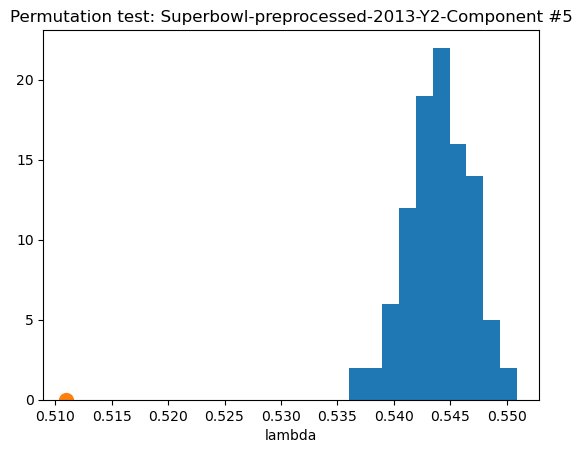

In [21]:
compo = 5
signifi = sum(lam_topK[:,compo-1]<lam[compo-1])/num_test*100
print("Component {compo}, top {signifi}%".format(compo=compo, signifi=signifi))
plt.hist(lam_topK[:,compo-1])
# plt.title('Permutation test: Example-'+'Component #'+str(compo))
plt.title('Permutation test: Superbowl-'+datatype+'-'+year+'-'+view+'-'+'Component #'+str(compo))
plt.xlabel('lambda')
plt.plot(lam[compo-1], 0, marker="o", markersize=10)

### Cross-validation

In [11]:
fold = 10
lam_train = np.zeros((fold, n_components))
lam_test = np.zeros_like(lam_train)
T, D, N = X_prepro.shape
for i in range(fold):
    len_test = T // fold
    X_test = X_prepro[len_test*i:len_test*(i+1),:,:]
    X_train = np.delete(X_prepro, range(len_test*i, len_test*(i+1)), axis=0)
    lam_train[i,:], W_train = GCCA(X_train, n_components=n_components, regularization='lwcov')
    X_test_list = [X_test[:,:,n] for n in range(N)]
    X_test_flatten = np.concatenate(tuple(X_test_list), axis=1)
    Rxx = LedoitWolf().fit(X_test_flatten).covariance_
    Dxx = np.zeros_like(Rxx)
    for n in range(N):
        Dxx[n*D:(n+1)*D,n*D:(n+1)*D] = Rxx[n*D:(n+1)*D,n*D:(n+1)*D]
    lam_test[i,:] = np.diag(np.transpose(W_train)@Dxx@W_train)


In [12]:
np.mean(lam_train, axis=0)

array([0.32933525, 0.46297041, 0.48598479, 0.49118173, 0.49606168])

In [13]:
np.mean(lam_test, axis=0)

array([0.38992864, 0.6473231 , 0.88495208, 0.99712886, 0.75150273])

### GCCA vs Correlated Component Analysis

In [16]:
ISC, W = corr_component(X_prepro, n_components=n_components)

In [17]:
ISC

array([0.04982424, 0.02942801, 0.02437868, 0.0175997 , 0.01655189])

In [18]:
avg_corr_coe(X_prepro, W, N, n_components=5)

array([0.0510326 , 0.0297898 , 0.02521335, 0.01767541, 0.01677557])

In [15]:
1/(1+(N-1)*ISC)

array([0.4421198 , 0.69659408, 0.76418215, 0.80520732, 0.81815575])

In [16]:
lam

array([0.33267204, 0.47261288, 0.50342761, 0.50565714, 0.51095894])